In [29]:
import os
import pydicom
import pandas as pd
import pydicom
import matplotlib.pyplot as plt

## part1:文件夹结构检查

In [8]:
def walk_dir(path, max_per_dir=5):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, "").count(os.sep)
        indent = "    " * level
        print(f"{indent}{os.path.basename(root)}/")
        dcm_count = 0
        for f in files:
            if not f.lower().endswith('.dcm'):
                print(f"{indent}    {f}")
                continue

            if dcm_count >= max_per_dir:
                print(f"{indent}    [跳过其余 {len(files) - files.index(f)} 个 .dcm 文件]")
                break

            fp = os.path.join(root, f)
            try:
                ds = pydicom.dcmread(fp, stop_before_pixels=True)  # 只读 metadata，不读像素
                print(f"{indent}    已读 {f} → PatientID={ds.get('PatientID','未知')}")
            except Exception as e:
                print(f"{indent}    读取 {f} 时出错：{e}")
            dcm_count += 1

In [9]:
walk_dir('manifest-1745037983505')

manifest-1745037983505/
    metadata.csv
    ACRIN-NSCLC-FDG-PET/
        LICENSE
        ACRIN-NSCLC-FDG-PET-001/
            01-10-1960-NA-Abdomen1WBPETCT-36994/
                2.000000-Abd.CT 5.0 B30s-63370/
                    已读 1-001.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-002.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-003.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-004.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-005.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    [跳过其余 351 个 .dcm 文件]
                606.000000-PET WB-67447/
                    已读 1-001.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-002.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-003.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-004.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                    已读 1-005.dcm → PatientID=ACRIN-NSCLC-FDG-PET-001
                

## part2:遍历数据，记录header信息

In [10]:
def load_all_metadata(base_path: str) -> (pd.DataFrame, pd.DataFrame):
    # —— 1. CSV —— 
    csv_path = os.path.join(base_path, 'metadata.csv')
    if os.path.exists(csv_path):
        df_csv = pd.read_csv(csv_path)
    else:
        print(f"⚠️There is no such a metadata.csv file in the pash:{base_path} ")
        df_csv = pd.DataFrame()

    # —— 2. DICOM —— 
    records = []
    for root, _, files in os.walk(base_path):
        for f in files:
            if not f.lower().endswith('.dcm'):
                continue
            path = os.path.join(root, f)
            try:
                ds = pydicom.dcmread(path, stop_before_pixels=True)
                records.append({
                    'PatientID': ds.get('PatientID', ''),
                    'StudyDate': ds.get('StudyDate', ''),
                    'Modality':  ds.get('Modality', ''),
                    'FilePath':  path
                })
            except Exception as e:
                records.append({
                    'PatientID': 'Error',
                    'StudyDate': '',
                    'Modality':  '',
                    'FilePath':  f"Failed to read {path}: {e}"
                })

    df_dcm = pd.DataFrame(records)
    return df_csv, df_dcm


In [ ]:
base_path = 'manifest-1745037983505/'
df_meta, df_dcm = load_all_metadata(base_path)

In [ ]:
df_meta.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.99.1071.30234098161697...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG2923,A056396,1.3.6.1.4.1.14519.5.2.1.99.1071.18898244484379...,PET CT FDG IMAG SKULL TO THIGH,04-09-1901,PET AC,GE MEDICAL SYSTEMS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,299,24.11 MB,.\COVID-19-NY-SBU\A056396\04-09-1901-NA-PET CT...,2025-04-19T14:46:52.259
1,1.3.6.1.4.1.14519.5.2.1.99.1071.17468448140319...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG2923,A113004,1.3.6.1.4.1.14519.5.2.1.99.1071.42964349729833...,PET CT FDG IMAG SKULL TO THIGH,10-30-1900,PET WB AC,SIEMENS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,251,15.24 MB,.\COVID-19-NY-SBU\A113004\10-30-1900-NA-PET CT...,2025-04-19T14:46:54.053
2,1.3.6.1.4.1.14519.5.2.1.99.1071.17485489156024...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG2923,A389295,1.3.6.1.4.1.14519.5.2.1.99.1071.15448604039589...,PET CT FDG IMAG SKULL TO THIGH,09-29-1900,PET AC,GE MEDICAL SYSTEMS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,299,24.11 MB,.\COVID-19-NY-SBU\A389295\09-29-1900-NA-PET CT...,2025-04-19T14:47:02.498
3,1.3.6.1.4.1.14519.5.2.1.99.1071.29461637259367...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG2923,A113004,1.3.6.1.4.1.14519.5.2.1.99.1071.42964349729833...,PET CT FDG IMAG SKULL TO THIGH,10-30-1900,CT WB 4.0 B30f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,376,198.53 MB,.\COVID-19-NY-SBU\A113004\10-30-1900-NA-PET CT...,2025-04-19T14:47:21.454
4,1.3.6.1.4.1.14519.5.2.1.99.1071.22933848075188...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG2923,A056396,1.3.6.1.4.1.14519.5.2.1.99.1071.18898244484379...,PET CT FDG IMAG SKULL TO THIGH,04-09-1901,WB STANDARD 2.5,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,390,206.34 MB,.\COVID-19-NY-SBU\A056396\04-09-1901-NA-PET CT...,2025-04-19T14:47:42.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1.3.6.1.4.1.14519.5.2.1.7777.4006.245370922432...,TCGA-PRAD,NaN,https://doi.org/10.7937/K9/TCIA.2016.YXOGLM4Y,TCGA-VP-A879,1.3.6.1.4.1.14519.5.2.1.7777.4006.121426539946...,Prostate CA PET,05-18-1991,PET WB,CPS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,356,12.87 MB,.\TCGA-PRAD\TCGA-VP-A879\05-18-1991-NA-Prostat...,2025-04-19T14:58:13.782
100,1.3.6.1.4.1.14519.5.2.1.7777.4006.310444141025...,TCGA-PRAD,NaN,https://doi.org/10.7937/K9/TCIA.2016.YXOGLM4Y,TCGA-VP-A87D,1.3.6.1.4.1.14519.5.2.1.7777.4006.122335913493...,TUMOR PET RES,08-22-1992,PET WB,SIEMENS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,324,19.55 MB,.\TCGA-PRAD\TCGA-VP-A87D\08-22-1992-NA-TUMOR P...,2025-04-19T14:58:19.021
101,1.3.6.1.4.1.14519.5.2.1.3983.4016.100252194388...,TCGA-BLCA,NaN,https://doi.org/10.7937/K9/TCIA.2016.8LNG8XDR,TCGA-K4-A4AC,1.3.6.1.4.1.14519.5.2.1.3983.4016.324995427785...,PET CT SKULL BASE TO MID THIGH,07-22-2006,CT 3.75 mm,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,267,140.83 MB,.\TCGA-BLCA\TCGA-K4-A4AC\07-22-2006-NA-PET CT ...,2025-04-19T14:58:43.53
102,1.3.6.1.4.1.14519.5.2.1.7777.4006.557095068009...,TCGA-PRAD,NaN,https://doi.org/10.7937/K9/TCIA.2016.YXOGLM4Y,TCGA-VP-A87D,1.3.6.1.4.1.14519.5.2.1.7777.4006.122335913493...,TUMOR PET RES,08-22-1992,ACCT,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,324,170.91 MB,.\TCGA-PRAD\TCGA-VP-A87D\08-22-1992-NA-TUMOR P...,2025-04-19T14:58:48.834


In [ ]:
df_dcm

,PatientID,StudyDate,Modality,FilePath
0,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...
1,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...
2,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...
3,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...
4,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...
...,...,...,...,...
30301,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...
30302,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...
30303,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...
30304,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...


## part3: 数据检查

#### metadata

In [ ]:
# 1. Overview: shape, dtypes, non-null counts
print("=== Basic Info ===")
print(df_meta.info(), "\n")

# 2. Unique value counts per column
print("=== Unique Value Counts per Column ===")
print(df_meta.nunique(), "\n")

# 3. Missing value counts per column
print("=== Missing Value Counts ===")
print(df_meta.isnull().sum(), "\n")

# 4. Numeric summary for 'Number of Images'
print("=== Numeric Summary: Number of Images ===")
print(df_meta['Number of Images'].describe(), "\n")

# 5. Parse and summarize File Size (assuming format like "xx.xx MB")
df_meta['FileSizeMB'] = (
    df_meta['File Size']
    .str.replace(r'\s*MB', '', regex=True)
    .astype(float)
)
print("=== Numeric Summary: FileSizeMB ===")
print(df_meta['FileSizeMB'].describe(), "\n")

# 6. Categorical value distributions
for col in ['Collection', 'Modality', 'Manufacturer']:
    if col in df_meta.columns:
        print(f"=== Value Distribution: {col} ===")
        print(df_meta[col].value_counts(), "\n")

# 7. Date distribution by year
df_meta['StudyDate'] = pd.to_datetime(
    df_meta['Study Date'], format='%m-%d-%Y', errors='coerce'
)
print("=== Year Distribution of Study Date ===")
print(df_meta['StudyDate'].dt.year.value_counts().sort_index(), "\n")



=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Series UID            104 non-null    object        
 1   Collection            104 non-null    object        
 2   3rd Party Analysis    8 non-null      object        
 3   Data Description URI  104 non-null    object        
 4   Subject ID            104 non-null    object        
 5   Study UID             104 non-null    object        
 6   Study Description     102 non-null    object        
 7   Study Date            104 non-null    object        
 8   Series Description    104 non-null    object        
 9   Manufacturer          104 non-null    object        
 10  Modality              104 non-null    object        
 11  SOP Class Name        104 non-null    object        
 12  SOP Class UID         104 non-null    object        
 13  N

#### dicom data

In [ ]:
def eda_dicom_df(df_dcm: pd.DataFrame):
    """
    Perform basic EDA on the DICOM metadata DataFrame:
    Columns: PatientID, StudyDate (YYYYMMDD), Modality, FilePath
    """
    print("=== Overview ===")
    print(f"Shape: {df_dcm.shape}")
    print("Data types & non-null counts:")
    df_dcm.info()
    print()

    print("=== Unique value counts per column ===")
    print(df_dcm.nunique())
    print()

    print("=== Missing value counts per column ===")
    print(df_dcm.isnull().sum())
    print()

    # Distribution of modalities
    print("=== Modality distribution ===")
    print(df_dcm['Modality'].value_counts())
    print()

    # How many unique patients?
    n_patients = df_dcm['PatientID'].nunique()
    print(f"=== Number of unique PatientIDs: {n_patients} ===\n")

    # Files per patient (top 10 busiest)
    print("=== Top 10 patients by number of files ===")
    print(df_dcm.groupby('PatientID').size().sort_values(ascending=False).head(10))
    print()

    # Parse StudyDate and show range + counts by year
    df_dcm['StudyDateParsed'] = pd.to_datetime(df_dcm['StudyDate'], format='%Y%m%d', errors='coerce')
    print("=== Study date range ===")
    print(df_dcm['StudyDateParsed'].agg(['min', 'max']))
    print()

    print("=== Series count by year ===")
    print(df_dcm['StudyDateParsed'].dt.year.value_counts().sort_index())
    print()


In [21]:
eda_dicom_df(df_dcm)

=== Overview ===
Shape: (30306, 4)
Data types & non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30306 entries, 0 to 30305
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PatientID  30306 non-null  object
 1   StudyDate  30306 non-null  object
 2   Modality   30306 non-null  object
 3   FilePath   30306 non-null  object
dtypes: object(4)
memory usage: 947.2+ KB

=== Unique value counts per column ===
PatientID       46
StudyDate       49
Modality         2
FilePath     30306
dtype: int64

=== Missing value counts per column ===
PatientID    0
StudyDate    0
Modality     0
FilePath     0
dtype: int64

=== Modality distribution ===
Modality
CT    15887
PT    14419
Name: count, dtype: int64

=== Number of unique PatientIDs: 46 ===

=== Top 10 patients by number of files ===
PatientID
ACRIN-NSCLC-FDG-PET-005    1519
ACRIN-NSCLC-FDG-PET-001    1325
ACRIN-NSCLC-FDG-PET-002    1238
TCGA-50-5072               

### data merge

In [26]:
def merge_dcm_and_meta(df_dcm: pd.DataFrame,
                       df_meta: pd.DataFrame,
                       base_dir: str) -> pd.DataFrame:
    df_meta = df_meta.copy()
    df_meta['path_norm'] = (
        df_meta['File Location']
          .str.replace('\\', '/', regex=False)   
          .str.lstrip('./')                      
    )
    df_dcm = df_dcm.copy()
    df_dcm['path_norm'] = (
      df_dcm['FilePath']
        .str.replace('\\', '/', regex=False)
        .str.replace(f'{base_dir}/', '', regex=False)
        .str.rsplit('/', n=1)       # 这里把 n=1 用关键字形式
        .str[0]
    )
    merged = pd.merge(
        df_dcm,
        df_meta,
        on='path_norm',
        how='left',
        validate='many_to_one',
        suffixes=('', '_meta')
    )

    merged = merged.drop(columns=['path_norm', 'File Location'], errors='ignore')

    return merged


In [ ]:
base_dir = 'manifest-1745037983505'
df_merged = merge_dcm_and_meta(df_dcm, df_meta, base_dir)
df_merged

,PatientID,StudyDate,Modality,FilePath,StudyDateParsed,path_prefix,Series UID,Collection,3rd Party Analysis,Data Description URI,...,Series Description,Manufacturer,Modality_meta,SOP Class Name,SOP Class UID,Number of Images,File Size,Download Timestamp,FileSizeMB,StudyDate_meta
0,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...,1960-01-10,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7009.2403.798861112144...,ACRIN-NSCLC-FDG-PET,NaN,https://doi.org/10.7937/tcia.2019.30ilqfcl,...,Abd.CT 5.0 B30s,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,356,187.86 MB,2025-04-19T14:48:35.981,187.86,1960-01-10
1,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...,1960-01-10,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7009.2403.798861112144...,ACRIN-NSCLC-FDG-PET,NaN,https://doi.org/10.7937/tcia.2019.30ilqfcl,...,Abd.CT 5.0 B30s,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,356,187.86 MB,2025-04-19T14:48:35.981,187.86,1960-01-10
2,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...,1960-01-10,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7009.2403.798861112144...,ACRIN-NSCLC-FDG-PET,NaN,https://doi.org/10.7937/tcia.2019.30ilqfcl,...,Abd.CT 5.0 B30s,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,356,187.86 MB,2025-04-19T14:48:35.981,187.86,1960-01-10
3,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...,1960-01-10,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7009.2403.798861112144...,ACRIN-NSCLC-FDG-PET,NaN,https://doi.org/10.7937/tcia.2019.30ilqfcl,...,Abd.CT 5.0 B30s,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,356,187.86 MB,2025-04-19T14:48:35.981,187.86,1960-01-10
4,ACRIN-NSCLC-FDG-PET-001,19600110,CT,manifest-1745037983505/ACRIN-NSCLC-FDG-PET\ACR...,1960-01-10,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7009.2403.798861112144...,ACRIN-NSCLC-FDG-PET,NaN,https://doi.org/10.7937/tcia.2019.30ilqfcl,...,Abd.CT 5.0 B30s,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,356,187.86 MB,2025-04-19T14:48:35.981,187.86,1960-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30301,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...,1998-10-23,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7777.4020.855737568592...,TCGA-UCEC,NaN,https://doi.org/10.7937/K9/TCIA.2016.GKJ0ZWAC,...,CT WB 5.0 B31f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,389,205.16 MB,2025-04-19T14:57:32.55,205.16,1998-10-23
30302,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...,1998-10-23,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7777.4020.855737568592...,TCGA-UCEC,NaN,https://doi.org/10.7937/K9/TCIA.2016.GKJ0ZWAC,...,CT WB 5.0 B31f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,389,205.16 MB,2025-04-19T14:57:32.55,205.16,1998-10-23
30303,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...,1998-10-23,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7777.4020.855737568592...,TCGA-UCEC,NaN,https://doi.org/10.7937/K9/TCIA.2016.GKJ0ZWAC,...,CT WB 5.0 B31f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,389,205.16 MB,2025-04-19T14:57:32.55,205.16,1998-10-23
30304,TCGA-FI-A2D5,19981023,CT,manifest-1745037983505/TCGA-UCEC\TCGA-FI-A2D5\...,1998-10-23,manifest-1745037983505,1.3.6.1.4.1.14519.5.2.1.7777.4020.855737568592...,TCGA-UCEC,NaN,https://doi.org/10.7937/K9/TCIA.2016.GKJ0ZWAC,...,CT WB 5.0 B31f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,389,205.16 MB,2025-04-19T14:57:32.55,205.16,1998-10-23


### 可视化检查

In [32]:
df_merged['FilePath'].iloc[0]

'manifest-1745037983505/ACRIN-NSCLC-FDG-PET\\ACRIN-NSCLC-FDG-PET-001\\01-10-1960-NA-Abdomen1WBPETCT-36994\\2.000000-Abd.CT 5.0 B30s-63370\\1-001.dcm'

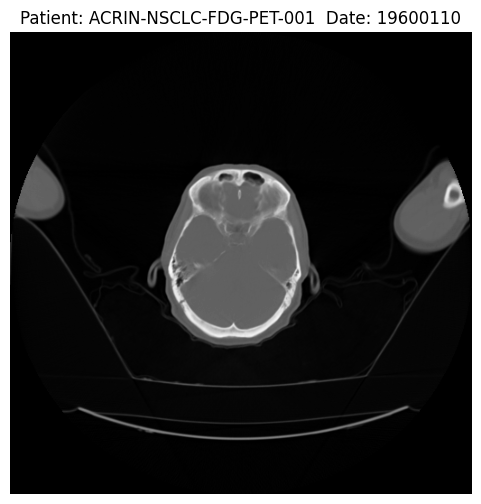

In [34]:
filepath = df_merged['FilePath'].iloc[0]
ds = pydicom.dcmread(filepath)
img = ds.pixel_array
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title(f"Patient: {ds.get('PatientID','Unknown')}  Date: {ds.get('StudyDate','')}")
plt.axis('off')
plt.show()
